In [1]:
# !pip install diffusers==0.30.0 #we will see deprcations so this can matter in the future


import torch
import intel_extension_for_pytorch as ipex
from diffusers import StableDiffusionPipeline

C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.bfloat16)
pipe = pipe.to("xpu")

Loading pipeline components...:  14%|███████▍                                            | 1/7 [00:00<00:05,  1.08it/s]C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]


In [14]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
out=pipe.tokenizer('cat sitting on a chair')
out

{'input_ids': [49406, 2368, 4919, 525, 320, 4269, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [5]:
input_ids=torch.IntTensor([out['input_ids']]).to('xpu')
input_ids

tensor([[49406,  2368,  4919,   525,   320,  4269, 49407]], device='xpu:0',
       dtype=torch.int32)

In [6]:
embedings=pipe.text_encoder(input_ids)
{k:v.shape for k,v in embedings.items()}

{'last_hidden_state': torch.Size([1, 7, 768]),
 'pooler_output': torch.Size([1, 768])}

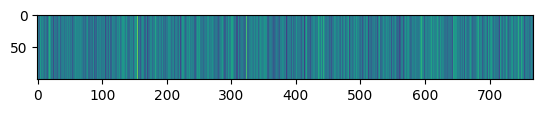

In [10]:
import matplotlib.pyplot as plt

img=embedings.pooler_output[0].cpu().float().detach()#.numpy()
img=torch.stack([img for _ in range(100)]).numpy()
plt.imshow(img)


In [30]:

history=[]
def save_ims(step: int, timestep: int, latents: torch.FloatTensor):
  history.append(pipe.decode_latents(latents.clone()))
prompt = "portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta"
with torch.no_grad():
    output = pipe(prompt,callback=save_ims,num_inference_steps=100,callback_steps=1,guidance_scale=7.)
output

C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:869: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:875: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
  1%|▊                                                                                 | 1/100 [00:02<03:22,  2.05s/it]C:\Users\intel\miniforge3\envs\work_env\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. P

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x19728F26790>], nsfw_content_detected=[False])

In [31]:
# help(pipe.__call__)

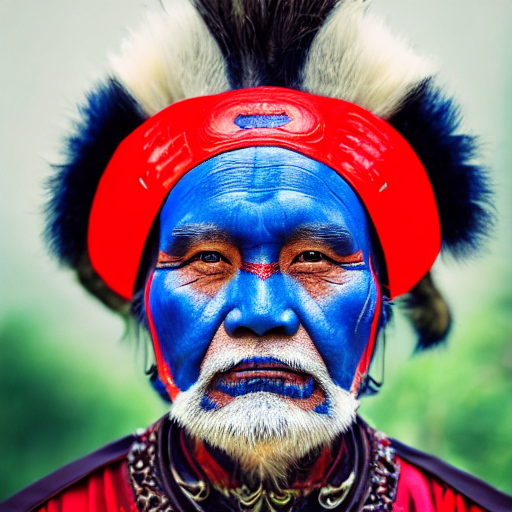

In [32]:
output.images[0]

In [33]:
from PIL import Image
import numpy as np

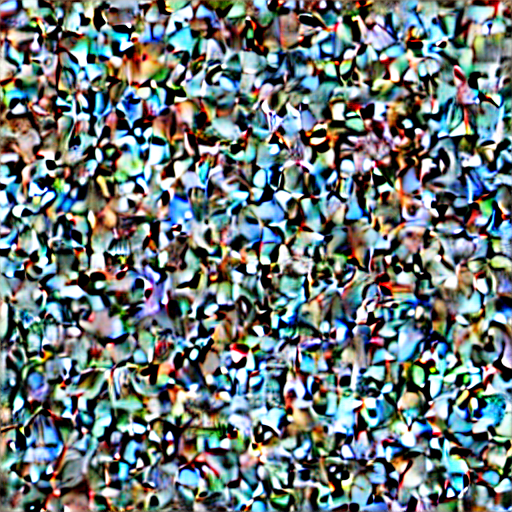

In [34]:
images=[pipe.numpy_to_pil(x)[0] for x in history]
images[0]

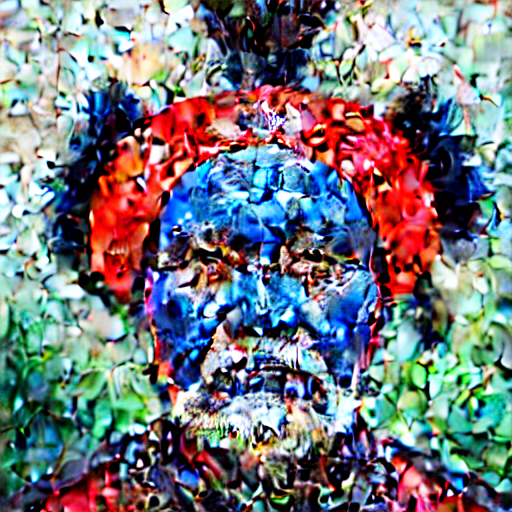

In [35]:
images[61]

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

#img = images # some array of images
def make_animation(img,dir='diffustion.gif'):
  frames = [] # for storing the generated images
  fig = plt.figure()
  for x in history:
      frames.append([plt.imshow(x[0],animated=True)])

  ani = animation.ArtistAnimation(fig, frames, interval=150, blit=True,
                                  repeat_delay=1000)
  ani.save(dir)

make_animation(images)
plt.show()

<IPython.core.display.Javascript object>

2024-09-09 03:23:37,281 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-09-09 03:23:37,281 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


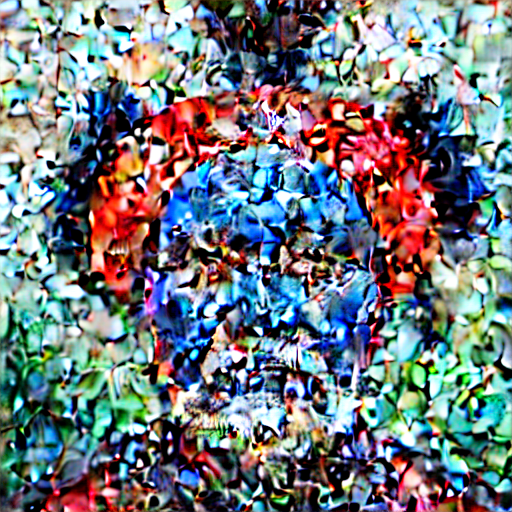

In [37]:
images[-50]

In [ ]:
mem=history
history=[]

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

In [ ]:
pipe2=StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe2 = pipe2.to("xpu")
#pipe2

In [ ]:
history=[]
prompt = "portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes, 50mm portrait photography, hard rim lighting photography–beta –ar 2:3 –beta –upbeta –upbeta "
output = pipe2(prompt,images[-35],callback=save_ims,num_inference_steps=100,guidance_scale=10.,strength=0.3)
output.images[0]
prompt

In [ ]:
text

In [ ]:
output.images[0].save('dragon.jpg')

  0%|          | 0/90 [00:00<?, ?it/s]

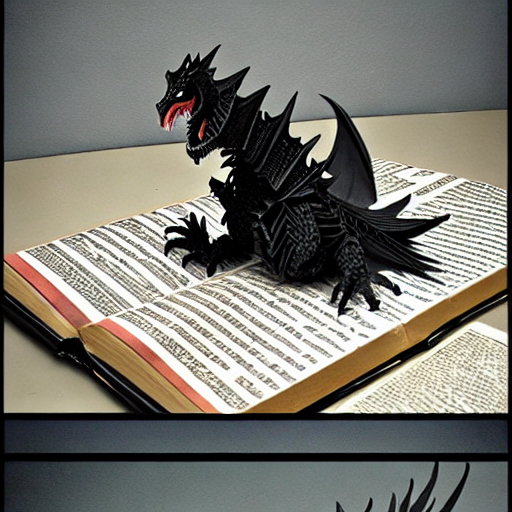

In [ ]:
history=[]
prompt = "black dragon made of books and paper detailed fantasy"
output = pipe2(prompt,images[-50],callback=save_ims,num_inference_steps=100,guidance_scale=10.,strength=0.9)
output.images[0]

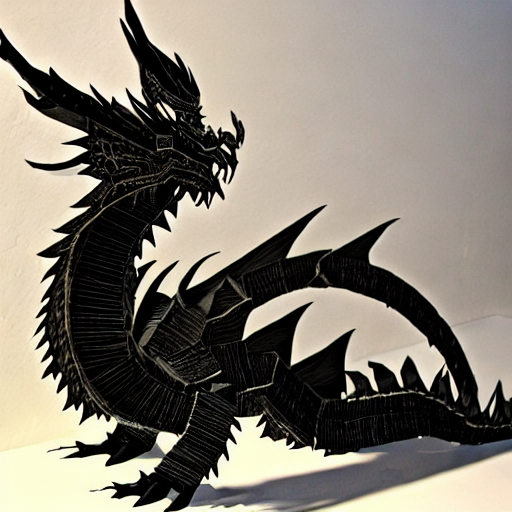

In [ ]:
images2=[pipe.numpy_to_pil(x)[0] for x in history]
images2[-1]

In [ ]:
make_animation(images2)

<IPython.core.display.Javascript object>